In [1]:
# permite a utilização de caminhos relativos ao projeto, mesmo no diretório de notebooks
import numpy as np
import random
from knapsax.optimization import Knapsack, Solution
import matplotlib.pyplot as plt
from knapsax.populational import Populational

from knapsax.utils import setrootdir

setrootdir("knapsax")

'Directory knapsax successfully loaded as current working directory.'

In [2]:
knapsack = Knapsack(instance_file="data/knapsack-instance.txt")
knapsack

Knapsack(file=data/knapsack-instance.txt, n_items=100, capacity=1550)

In [3]:
capacidade = knapsack.capacity
pesos = knapsack.items

In [4]:
print(capacidade)
print(pesos)

1550
[Item(value=91, weight=74), Item(value=20, weight=16), Item(value=81, weight=58), Item(value=50, weight=35), Item(value=76, weight=72), Item(value=30, weight=15), Item(value=85, weight=77), Item(value=65, weight=52), Item(value=44, weight=28), Item(value=70, weight=63), Item(value=60, weight=45), Item(value=25, weight=19), Item(value=88, weight=66), Item(value=55, weight=40), Item(value=33, weight=23), Item(value=95, weight=81), Item(value=18, weight=12), Item(value=62, weight=50), Item(value=42, weight=31), Item(value=75, weight=68), Item(value=51, weight=37), Item(value=68, weight=54), Item(value=39, weight=25), Item(value=90, weight=79), Item(value=58, weight=43), Item(value=72, weight=60), Item(value=29, weight=21), Item(value=64, weight=48), Item(value=82, weight=70), Item(value=47, weight=33), Item(value=78, weight=64), Item(value=40, weight=27), Item(value=71, weight=56), Item(value=54, weight=39), Item(value=89, weight=75), Item(value=26, weight=18), Item(value=77, weight=

# PSO

In [5]:
# def particula(tamanho):
#     posicao = [random.randint(0, 1) for _ in range(tamanho)]
#     velocidade = [random.uniform(-1, 1) for _ in range(tamanho)]
#     return [posicao, posicao.copy(), velocidade]

In [6]:
import numpy as np
from knapsax.optimization import Knapsack, ObjectiveFunction, Maximize

class PSOBinario:
    def __init__(self, knapsack, num_particulas=50, max_avaliacoes=20000):
        self.knapsack = knapsack
        self.obj_func = ObjectiveFunction()
        self.criterio = Maximize()
        self.n = self.knapsack.n_items
        self.capacidade = self.knapsack.capacity
        self.itens = self.knapsack.items
        self.num_particulas = num_particulas
        self.max_avaliacoes = max_avaliacoes

    def fitness(self, bits):
        total_valor = 0
        total_peso = 0
        for i in range(self.n):
            if bits[i] == 1:
                total_valor += self.itens[i].value
                total_peso += self.itens[i].weight
                if total_peso > self.capacidade:
                    return 0
        return total_valor

    def run(self):
        w, c1, c2 = 0.7, 1.5, 1.5
        posicoes = np.random.randint(0, 2, (self.num_particulas, self.n))
        velocidades = np.random.uniform(-1, 1, (self.num_particulas, self.n))
        pbest = posicoes.copy()
        pbest_val = np.array([self.fitness(p) for p in pbest])
        gbest_idx = np.argmax(pbest_val)
        gbest = pbest[gbest_idx].copy()
        gbest_val = pbest_val[gbest_idx]

        avaliacoes = self.num_particulas

        while avaliacoes < self.max_avaliacoes:
            for i in range(self.num_particulas):
                r1, r2 = np.random.rand(self.n), np.random.rand(self.n)

                velocidades[i] = (
                    w * velocidades[i]
                    + c1 * r1 * (pbest[i] - posicoes[i])
                    + c2 * r2 * (gbest - posicoes[i])
                )

                posicoes[i] = np.where(velocidades[i] > 0, 1, 0)

                f = self.fitness(posicoes[i])
                avaliacoes += 1

                if self.criterio(f, pbest_val[i]):
                    pbest[i] = posicoes[i].copy()
                    pbest_val[i] = f
                    if self.criterio(f, gbest_val):
                        gbest = posicoes[i].copy()
                        gbest_val = f

                if avaliacoes >= self.max_avaliacoes:
                    break

        return gbest_val


In [7]:
pso = PSOBinario(knapsack)
resultado = pso.run()
print("Melhor valor encontrado:", resultado)

Melhor valor encontrado: 2084


In [8]:
melhorias = 0
ult_gbest = resultado

# dentro do while:
if resultado > ult_gbest:
    melhorias = 0
    ult_gbest = resultado
else:
    melhorias += 1

if melhorias >= 100:  # 100 iterações sem melhorar
    print("Convergiu por estagnação.")

In [ ]:
import matplotlib.pyplot as plt

historico = []

# dentro do while:
historico.append(gbest_val)

# depois do algoritmo:
plt.plot(historico)
plt.xlabel("Avaliações")
plt.ylabel("Melhor valor")
plt.title("Convergência do PSO")
plt.grid()
plt.show()

# PSO Teste 2

In [74]:
class Particula:
    def __init__(self, weights, values, capacity):
        self.weights = weights
        self.values = values
        self.capacity = capacity
        self.num_items = len(weights)

        self.position = self.generate_feasible_position()
        self.velocity = np.random.uniform(-1, 1, size=self.num_items)

        self.best_position = self.position.copy()
        self.best_fitness = self.evaluate()

    def generate_feasible_position(self):
        position = np.zeros(self.num_items, dtype=int)
        total_weight = 0
        indices = np.random.permutation(self.num_items)
        for i in indices:
            if total_weight + self.weights[i] <= self.capacity:
                position[i] = 1
                total_weight += self.weights[i]
        return position

    def evaluate(self):
        total_weight = np.sum(self.position * self.weights)
        if total_weight > self.capacity:
            return 0
        return np.sum(self.position * self.values)

    def update_velocity(self, global_best, inertia, c1, c2, min_v, max_v):
        r1 = np.random.rand(self.num_items)
        r2 = np.random.rand(self.num_items)
        cognitive = c1 * r1 * (self.best_position - self.position)
        social = c2 * r2 * (global_best - self.position)
        self.velocity = inertia * self.velocity + cognitive + social
        self.velocity = np.clip(self.velocity, -min_v, max_v)

    def update_position(self):
        prob = 1 / (1 + np.exp(-self.velocity))
        self.position = np.where(np.random.rand(self.num_items) < prob, 1, 0)

In [84]:
class pso_knapsack:
    def __init__(self, weights, values, capacity, num_particles=100, max_evals=20000,
                 inertia=1.0, c1=0.5, c2=0.5, min_velocity=4, max_velocity=4):

        self.weights = weights
        self.values = values
        self.capacity = capacity
        num_itens = len(weights)
    
        self.num_particles = num_particles
        self.max_evals = max_evals
        self.inertia = inertia
        self.c1 = c1
        self.c2 = c2
        self.min_velocity = min_velocity
        self.max_velocity = max_velocity
    
        self.history = []

    def run(self):    
        swarm = [Particula(self.weights, self.values, self.capacity) for _ in range(self.num_particles)]
        global_best = swarm[0].best_position.copy()
        global_best_fitness = swarm[0].best_fitness
    
        evals = self.num_particles
        self.history.append(global_best_fitness)
    
        while evals < self.max_evals:
            for particle in swarm:
                particle.update_velocity(global_best, self.inertia, self.c1, self.c2, self.min_velocity, self.max_velocity)
                particle.update_position()
                fitness = particle.evaluate()
                evals += 1
    
                if fitness > particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = particle.position.copy()
    
                if fitness > global_best_fitness:
                    global_best_fitness = fitness
                    global_best = particle.position.copy()
    
                if evals >= self.max_evals:
                    break
            self.history.append(global_best_fitness)
        return global_best, global_best_fitness, self.history

In [92]:
# --------- Execução ---------
num_items = knapsack.n_items
capacity = knapsack.capacity
weights = [item.weight for item in knapsack.items]
values = [item.value for item in knapsack.items]

pso = pso_knapsack(weights, values, capacity)
solution, best_value, history = pso.run()

total_weight = np.sum(best_position * weights)

print("Melhor valor:", best_value)
print("Peso total:", total_weight)
print("Itens escolhidos (índices):", np.where(best_position == 1)[0])

Melhor valor: 2157
Peso total: 1546
Itens escolhidos (índices): [ 0  5 10 11 12 13 21 23 25 27 30 31 32 33 37 41 44 45 47 53 56 59 65 66
 71 72 73 74 76 78 83 85 89 90 92 97]


Melhor valor encontrado: 2168
Peso total: 1547
Itens selecionados: [ 2  3  5  8 10 12 13 14 16 18 20 26 29 31 35 37 38 40 41 42 44 47 49 51
 53 55 58 60 62 66 67 68 70 72 76 79 81 83 85 87 89 90 92 95 97 99]


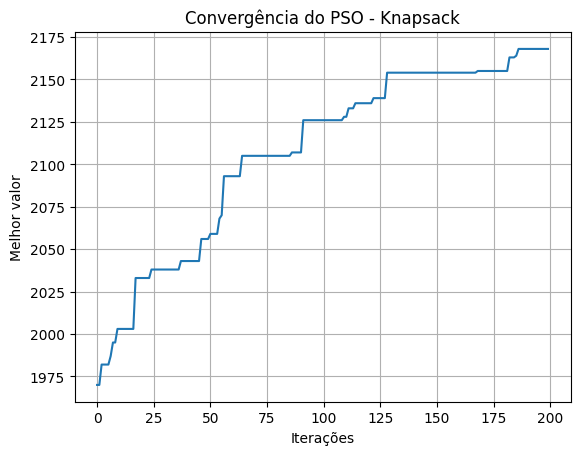

In [90]:
# Exibe resultados
print("Melhor valor encontrado:", best_value)
print("Peso total:", np.sum(solution * weights))
print("Itens selecionados:", np.where(solution == 1)[0])

# Plota convergência
plt.plot(history)
plt.xlabel("Iterações")
plt.ylabel("Melhor valor")
plt.title("Convergência do PSO - Knapsack")
plt.grid()
plt.show()


In [94]:
best_value_global = 0
best_solution_global = None

for _ in range(10):
    pso = pso_knapsack(weights, values, capacity)
    solution, value, _ = pso.run()
    if value > best_value_global:
        best_value_global = value
        best_solution_global = solution

print("Melhor valor encontrado:", best_value_global)
print("Peso total da solução:", sum(best_solution_global * weights))
print("Itens escolhidos:", [i for i, bit in enumerate(best_solution_global) if bit == 1])

Melhor valor encontrado: 2166
Peso total da solução: 1549
Itens escolhidos: [2, 3, 5, 8, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 27, 29, 33, 35, 37, 38, 40, 42, 44, 45, 47, 49, 51, 53, 56, 58, 60, 64, 66, 68, 71, 72, 74, 76, 79, 81, 85, 87, 92, 97, 99]
